## Dynamic Time Warping
#### Mapping Time Series By Geometry to an Appropriate Model
     
   - This notebook takes simulations of time series generated by various generative processes and clusters          them by applying kmedoids with the dynamic time warping distance metric. 
     
   - Optimal number of clusters is determined via silhouette analysis 

In [2]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import kmedoids
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample


### Simulate Time Series
    - Moving Average Series (beta coefficients)
    - Autoregressive Series (Alpha Coefficients)
    - Random Walk/Brownian Series

In [279]:
from pandas import read_csv
import pandas as pd
from pandas import datetime
from matplotlib import pyplot
import numpy as np
from tslearn.generators import random_walks
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from hurst import compute_Hc, random_walk

#def parser(x):
	#return datetime.strptime('190'+x, '%-%M-%d')
# Simulate an ARIMA(2,1,1) model 
# alphas=[0.5,-0.25] 
# betas=[-0.5]
import seaborn as sns
from statsmodels.tsa.arima_process import arma_generate_sample


ARMA1 = []
for seeds in range(0, 300):
    np.random.seed(seeds)
    max_lag = 30

    n = int(204)
    burn = 2000

    alphas = np.array([0])
    betas = np.array([-1, .2])

    ar = np.r_[1, -alphas]
    ma = np.r_[1, betas]

    arma11 = arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
    series1 = arma11.cumsum()
    ARMA1.append(series1)
    #pyplot.plot(series)
    
    
ARMA2 = []
for seeds in range(0, 300):
    np.random.seed(seeds)
    max_lag = 30

    n = int(204)
    burn = 2000

    alphas = np.array([-1, .4, 1, .2])
    betas = np.array([0])

    ar = np.r_[1, -alphas]
    ma = np.r_[1, betas]

    arma11 = arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
    series2 = arma11.cumsum()
    ARMA2.append(series2)
    #pyplot.plot(series)
    

#### Throwing in some brownian/chaotic random walks.

RW = []
for seeds in range(0, 300):
    np.random.seed(seeds)
    #Brownian Motion Series
    RWS = random_walk(204, proba=0.5)
    RW.append(RWS)

ARMA1 = pd.DataFrame(ARMA1)
ARMA2 = pd.DataFrame(ARMA2)
RW = pd.DataFrame(RW)
ARMA_all = pd.concat([ARMA1, ARMA2, RW])



print(ARMA1.shape, "ARMA1 Shape")
print(ARMA2.shape, "ARMA2 Shape")
print(RW.shape, "ARMA3 Shape")



size = int(len(ARMA_all) * 0.888)
train, test = ARMA_all[0:size], ARMA_all[size:len(ARMA_all)]
print(train.shape, "Train Shape")
print(test.shape, "Test Shape")


ARMA_matrix = np.matrix(ARMA_all)
print(ARMA_matrix.shape, "ARMA Matrix Shape")

(300, 204) ARMA1 Shape
(300, 204) ARMA2 Shape
(300, 204) ARMA3 Shape
(799, 204) Train Shape
(101, 204) Test Shape
(900, 204) ARMA Matrix Shape


### Time Series Standardization/Scaling 
    - Min/Max scaling was performed here - z-scaling could also be done and should be tested
    - Min/Max scaling gives us time series between 0 to 1, which mirrors the target dataset

In [284]:
### Min max normalization
#To normalize 3D time series tensor: (n_samples, timesteps, n_features)




ARMA_matrix_normalized = []

for timeseries in ARMA_matrix:
    normalized = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())
    ARMA_matrix_normalized.append(normalized)

ARMA_matrix_normalized = np.array(ARMA_matrix_normalized)

ARMA_matrix_normalized = ARMA_matrix_normalized.reshape(900,204)


print(ARMA_matrix.shape, "ARMA Matrix  Shape")
print(ARMA_matrix_normalized.shape, "ARMA Matrix Normalized Shape")

(900, 204) ARMA Matrix  Shape
(900, 204) ARMA Matrix Normalized Shape


### Time Series Plots

##### Moving Average Simulated Series (Unscaled)

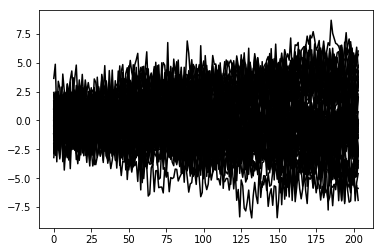

In [226]:

for ts in np.array(ARMA1[0:50]):
    plt.plot(ts.ravel(), "k-")

##### Autoregressive Series Simulated Series (Unscaled)

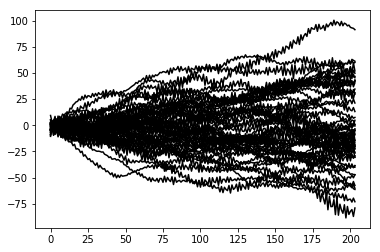

In [224]:
#### Weird looking AR()
for ts in np.array(ARMA2[0:50]):
    plt.plot(ts.ravel(), "k-")

##### Random Walk / Brownian Motion Simulated Series (Unscaled)

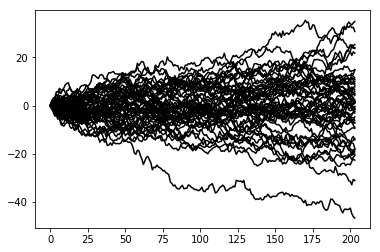

In [225]:

for ts in np.array(RW[0:50]):
    plt.plot(ts.ravel(), "k-")

###### Moving Average Simulated Series (Min/Max Scaled)

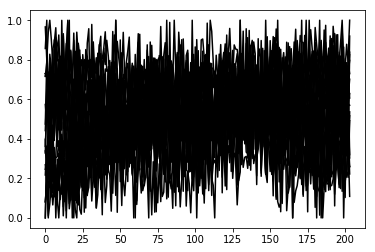

In [232]:
ARMA1_normalized = []
for timeseries in np.array(ARMA1):
    normalized = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())
    ARMA1_normalized.append(normalized)
    

for ts in np.array(ARMA1_normalized[0:20]):
    plt.plot(ts.ravel(), "k-")

###### Autoregressive Simulated Series (Min/Max Scaled)

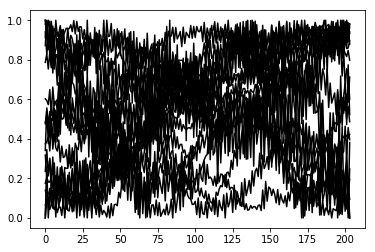

In [233]:
ARMA2_normalized = []
for timeseries in np.array(ARMA2):
    normalized = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())
    ARMA2_normalized.append(normalized)
    

for ts in np.array(ARMA2_normalized[0:20]):
    plt.plot(ts.ravel(), "k-")

###### Random Walk/Brownian Motion Simulated Series (Min/Max Scaled)

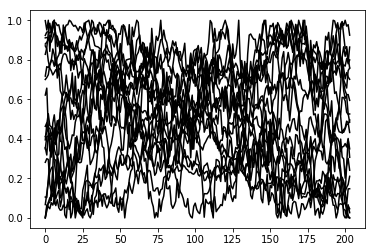

In [237]:
RW_normalized = []
for timeseries in np.array(RW):
    normalized = (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())
    RW_normalized.append(normalized)
    

for ts in np.array(RW_normalized[0:20]):
    plt.plot(ts.ravel(), "k-")

## K-Medoids Clustering (DTW) of simulated Series and Silhouette Analysis

In [241]:
import timeit
start_time = timeit.default_timer()
# code you want to evaluate




# create Minkowski distance metric with degree equals to '2'
from pyclustering.cluster import kmedoids
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.silhouette import silhouette
from pyclustering.utils.metric import type_metric, distance_metric

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering



metric_dtw = distance_metric(type_metric.USER_DEFINED, func=dtw.distance_fast)
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample


sil_scores_full = []

#grid searching 4 clusters 

### Medoids randomly initialized, here uniform 1. 
### Need to test this assumption.
initial_medoids_list = [[1, 1], [1,1,1], [1,1,1,1], [1,1,1,1,1], [1,1,1,1,1,1], [1,1,1,1,1,1,1,1]] 
for k in initial_medoids_list:
    # Create instance of K-Medoids algorithm.
    #Makeshift progress bar. 
    
    print(k)
    ### Check if  data_type='distance_matrix'), but shouldnt for input of original series. 
    kmedoids_instance = kmedoids(ARMA_matrix_normalized, k, metric=metric_dtw)

    # Run cluster analysis and obtain results.
    kmedoids_instance.process()

    clusters = kmedoids_instance.get_clusters()


    silhouette_instance = silhouette(ARMA_matrix_normalized, clusters, metric=metric_dtw) 
    score = silhouette_instance.process().get_score()
    sil_scores_full.append(score)

    
elapsed = timeit.default_timer() - start_time
print(elapsed)

[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
3967.1465177349746


In [283]:
ARMA_matrix_normalized.reshape(900,204)

(900, 204)

#### Silhouette Analysis Output

In [244]:

### Silhouette score is maximized at k = 3 clusters.

print(np.nanmean(sil_scores_full[0]))
print(np.nanmean(sil_scores_full[1]))
print(np.nanmean(sil_scores_full[2]))
print(np.nanmean(sil_scores_full[3]))
print(np.nanmean(sil_scores_full[4]))
print(np.nanmean(sil_scores_full[5]))


0.38149534541710056
0.27855064556958464
0.25544780306231735
0.24985261355560467
0.22197728401445588
0.2080715040452487


##### Re-run K-Medoids at k = 3 to retrieve results
     - Code above can be rewritten to contain model output

In [250]:
k = [1,1,1]

kmedoids_instance_final = kmedoids(ARMA_matrix_normalized, k, metric=metric_dtw)

# Run cluster analysis and obtain results.
kmedoids_instance_final.process()

clusters = kmedoids_instance_final.get_clusters()

In [251]:
print("Amount of clusters:", len(clusters));
for cluster in clusters:
    print("Cluster length:", len(cluster));

Amount of clusters: 3
Cluster length: 367
Cluster length: 276
Cluster length: 257


### Reformat/Organize Data with Cluster Membership labels

In [287]:
clusters1 = clusters[0]
clusters1_pd = pd.DataFrame(clusters1)
clusters1_pd.columns = ["index"]

clusters2 = clusters[1]
clusters2_pd = pd.DataFrame(clusters2)
clusters2_pd.columns = ["index"]

clusters3 = clusters[2]
clusters3_pd = pd.DataFrame(clusters3)
clusters3_pd.columns = ["index"]


In [350]:
Clustered_All = pd.concat([ARMA1, ARMA2, RW])

ARMA_matrix_normalized_pd = pd.DataFrame(ARMA_matrix_normalized)
ARMA_matrix_normalized_pd["index"] = ARMA_matrix_normalized_pd.index

cluster_sub_1 = clusters1_pd.join(ARMA_matrix_normalized_pd, on='index', how = 'left',  lsuffix='_l', rsuffix='_r')
cluster_sub_1["cluster_group"] = "cluster1"
cluster_sub_2 = clusters2_pd.join(ARMA_matrix_normalized_pd, on='index', how = 'left',  lsuffix='_l', rsuffix='_r')
cluster_sub_2["cluster_group"] = "cluster2"
cluster_sub_3 = clusters3_pd.join(ARMA_matrix_normalized_pd, on='index', how = 'left',  lsuffix='_l', rsuffix='_r')
cluster_sub_3["cluster_group"] = "cluster3"
Clustered_All = pd.concat([cluster_sub_1, cluster_sub_2, cluster_sub_3])

cluster_sub_1_index = cluster_sub_1["index_l"]
cluster_sub_1 = cluster_sub_1.drop('index_l', axis=1)
cluster_sub_1 = cluster_sub_1.drop('index_r', axis=1)
cluster_sub_1 = cluster_sub_1.drop('cluster_group', axis=1)
cluster_sub_1 = np.array(cluster_sub_1)

cluster_sub_2_index = cluster_sub_2["index_l"]
cluster_sub_2 = cluster_sub_2.drop('index_l', axis=1)
cluster_sub_2 = cluster_sub_2.drop('index_r', axis=1)
cluster_sub_2 = cluster_sub_2.drop('cluster_group', axis=1)
cluster_sub_2 = np.array(cluster_sub_2)

cluster_sub_3_index = cluster_sub_3["index_l"]
cluster_sub_3 = cluster_sub_3.drop('index_l', axis=1)
cluster_sub_3 = cluster_sub_3.drop('index_r', axis=1)
cluster_sub_3 = cluster_sub_3.drop('cluster_group', axis=1)
cluster_sub_3 = np.array(cluster_sub_3)

Clustered_All = Clustered_All.drop('index_l', axis = 1)

### This matches assignment from above. 
print("Cluster length 1:", len(cluster_sub_1))
print("Cluster length 1:", len(cluster_sub_2))
print("Cluster length 1:", len(cluster_sub_3))

Cluster length 1: 367
Cluster length 1: 276
Cluster length 1: 257


In [342]:
def func(x):
    if 0 < x <= 300:
        return 'ARMA1'
    elif 301 < x <= 600:
        return 'ARMA2'
    elif x > 600:
        return 'RW'
    return '0'

Clustered_All['simulated'] = Clustered_All['index_r'].apply(func)

In [ ]:
####

[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [103  57 140   0   0   0]
 [139 109  51   0   0   0]
 [125 109  65   0   0   0]]


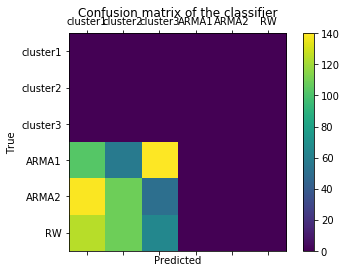

In [344]:
### Need to clean this up, not looking at this as a "Confusion Matrix" in the traditional sense,
### given we have not interpreted clusters. But, using it as a cross-tab heat plot
### to see which cluster groups correspond with which simulated group.

### The plot is messed up -- but, lower left quandrant seems to be informative. 
from sklearn.metrics import confusion_matrix

#confusion_matrix(Clustered_All['simulated'], Clustered_All['cluster_group'])

from sklearn.metrics import confusion_matrix

labels = ['cluster1', 'cluster2',  'cluster3', 'ARMA1', 'ARMA2', 'RW']
cm = confusion_matrix(Clustered_All['simulated'],  Clustered_All['cluster_group'], labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#### Cluster group 1 is distributed between ARMA 1 and 2. 

#### Cluster group 2 Is distributed between ARMA 2 and Random Walk

#### Cluster group 3 Is primarily ARMA1. 

#### Cluster group 3 does perhaps the best job of identifying ARMA1 type series. This result makes sense
### from a geometric perspective -- the MA series look different than the ARMA2(Autoregressive) and RW/Brownian, 
### which in the way that they are simulated, look alot like eachother. 


### So, we wouldn't know the real data generating process in practice, but this result is interesting 
### enough to probe further. 

### Time Series Plots of DTW Cluster Groups
     -- Examine Plots of the Cluster Grouped Series to determine how the series are being clusterd.
     -- Straight away cluster 3 could be identified as mean reverting, while cluster 2 and 3
     -- could be identified as series with trend. 
     
     -- **From the result above, we know throwing in brownian series that "looked like" our ARIMAs
          confusion things a bit. But straightaway, the dtw has at least organized the clusters
          into "series with trend up," "series with trend down," and series that 'look' more  "mean reverting"
          this alone might be helpful and, certain assumptions could be made, ie testing that the
          series are actually mean reverting (or non-stationary), and then specifying an appropriate
          representative model. 
          
      -- The trend series could be detrended -- also, we intentionally polluted the data with
         Brownian Series that are known to be "hard to predict." Just because they're hard to
         predict, doesn't mean they're not predictable in a sense -- furthermore, we can use 
         the hurst index to justify a baseline (prediction based on previous day only)
         for some of these series. 
         
         
      -- More granular dtw clusters could be explored -- also, clustering within the series themselves
         can be explored. 

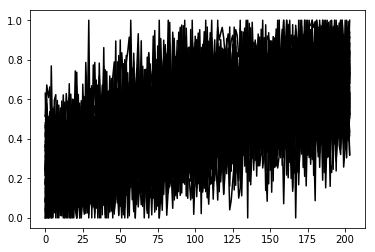

In [351]:
### From this plot it's clear that the dtw algorithm is associating series with an upward trend 
### in cluster group 1. 
for ts in cluster_sub_1[0:50]:
    plt.plot(ts.ravel(), "k-")

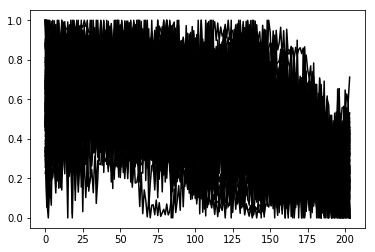

In [352]:
### Cluster group 2 is similarly honing in on downward trends. 

for ts in cluster_sub_2[0:70]:
    plt.plot(ts.ravel(), "k-")

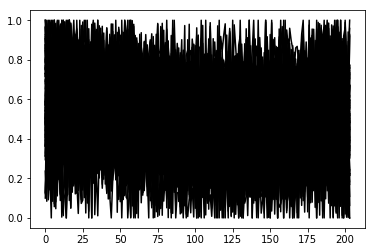

In [337]:
### Cluster group 3 found series of a more mean reverting nature ....
### This makes sense given our finding above associating cluster 3
### more-so with moving average components. 

for ts in cluster_sub_3[0:70]:
    plt.plot(ts.ravel(), "k-")

### Grid Search to Find Representative Parameter Specification
     - Assuming here we did not know the data generating process, 
       component series within the cluster results can be subject to
       statistical tests to hypothesize about their structure, 
       and also models can be fit (e.g., ARIMA) to determine appropriateness of
       fit. 
     
     - The parameter grid searches for individual series within the clusters can
       be more exhaustive , searching thousands of these would take alot of time.
       With stepwise =true, the full parameter space isn't explored (stopping
       mechanism based on AIC*(verify, this is from memory) is used here,
       it might not stop at the most optimal model.
       
     - Even if grid search can be done, grid search alone could produce overfit
       results. Visual diagnosis of the series are needed as well,
       and since dtw organized the series into groups, we can look
       for consistency on a limited amount of visual inspections.

In [ ]:
from pmdarima.arima import auto_arima

### Trying out seasonal models here -- since we haven't interpreted cluster 3 as nonseasonal yet.

#Chosen arbitrarily

ts_cluster3 = [1, 30, 2, 143, 23, 8]

SARIMA_pdq = []
model_seasonal_order = []
nonseasonal_pdq = []

for ts in ts_cluster3:
    series = cluster_sub_3[ts]

    #auto-ARIMA , assuming first difference 
    stepwise_model_SARIMA = auto_arima(series, start_p=1, start_q=1,
                               max_p=30, max_q=30, m=30,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    SARIMA_pdq.append(stepwise_model_SARIMA.order)
    
    model_seasonal_order.append(stepwise_model_SARIMA.seasonal_order)
    
    #auto-ARIMA , assuming first difference 
    stepwise_model = auto_arima(series, start_p=1, start_q=1,
                               max_p=30, max_q=30, m=30,
                               start_P=0, seasonal=False,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    nonseasonal_pdq.append(stepwise_model_SARIMA.order)
    

#### This result chose non-stationary MA 1!  So, this series is not quite mean reverting --- it was first 
#### Grid Search first differenced it to make it stationary -- but then an MA 1 term was selected. 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 30); AIC=-31.422, BIC=-15.656, Fit time=15.626 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 30); AIC=173.678, BIC=179.984, Fit time=0.118 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 30); AIC=39.160, BIC=51.773, Fit time=4.884 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 30); AIC=-23.612, BIC=-10.999, Fit time=11.162 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 30); AIC=-29.411, BIC=-10.491, Fit time=17.104 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 30); AIC=26.289, BIC=38.902, Fit time=0.594 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 30); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 30); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 30); AIC=-29.903, BIC=-10.983, Fit time=19.328 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 30); AIC=8.843

In [358]:
stepwise_model.seasonal_order

(0, 1, 1, 12)